In [1]:
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.applications import InceptionV3
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD,Adam,RMSprop
from keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/My Drive/train.zip'



Archive:  /content/drive/My Drive/train.zip
replace train/cat.10011.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
filenames = os.listdir('train')

In [6]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("1")
    else:
        categories.append("0")
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})        

In [7]:
df.shape

(26408, 2)

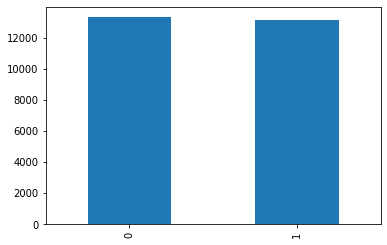

In [8]:
df['category'].value_counts().plot.bar()

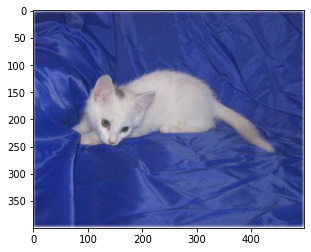

In [9]:
sample = np.random.choice(filenames)
image = load_img('train/'+sample)
plt.imshow(image)


In [13]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df , validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

19013 2113


In [14]:
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01,  patience=3, min_lr=1e-5)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(128,128,3))

for layer in base_model.layers:
   layer.trainable = False
    
    
model = Sequential()
model.add(base_model) 
model.add(Flatten()) 
model.add(Dense(512,activation=('relu')))
model.add(Dropout(.5))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.5))
model.add(Dense(1,activation=('sigmoid')))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [18]:
batch_size= 100
epochs=30

#Compiling the VGG19 model
model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
r = model.fit_generator(datagen.flow_from_dataframe(
    train_df, 
    "train",  x_col='filename', y_col='category',class_mode='binary',target_size=(128, 128),batch_size=batch_size),steps_per_epoch = total_train/batch_size,
      validation_data = validation_datagen.flow_from_dataframe(validate_df, 
    "train", x_col='filename',y_col='category',class_mode='binary',target_size=(128,128),batch_size=batch_size),validation_steps=total_validate/batch_size,epochs =epochs ,callbacks = [lrr], verbose = 1)




Found 19013 validated image filenames belonging to 2 classes.
Found 2113 validated image filenames belonging to 2 classes.
Epoch 1/30
191/190 [==============================] - 126s 658ms/step - loss: 0.2738 - accuracy: 0.8965 - val_loss: 0.1592 - val_accuracy: 0.9380
Epoch 2/30
191/190 [==============================] - 124s 647ms/step - loss: 0.2440 - accuracy: 0.9059 - val_loss: 0.1618 - val_accuracy: 0.9408
Epoch 3/30
191/190 [==============================] - 124s 648ms/step - loss: 0.2340 - accuracy: 0.9080 - val_loss: 0.1588 - val_accuracy: 0.9352
Epoch 4/30
191/190 [==============================] - 124s 647ms/step - loss: 0.2247 - accuracy: 0.9125 - val_loss: 0.1569 - val_accuracy: 0.9356
Epoch 5/30
191/190 [==============================] - 124s 648ms/step - loss: 0.2170 - accuracy: 0.9151 - val_loss: 0.1396 - val_accuracy: 0.9427
Epoch 6/30
191/190 [==============================] - 124s 649ms/step - loss: 0.2136 - accuracy: 0.9173 - val_loss: 0.1751 - val_accuracy: 0.9404
E

Text(0.5, 1.0, 'Accuracy evolution')

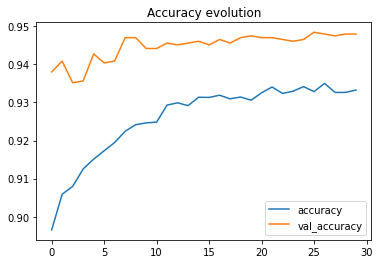

In [19]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')


In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(test_df, 'train', x_col='filename',y_col='category',class_mode='binary',
                                              batch_size=64,target_size=(128, 128),shuffle=False)

_, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print(acc)

Found 5282 validated image filenames belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
0.943203330039978


In [27]:
pred = model.predict_generator(test_generator)
for i in range(len(pred)):
  if pred[i]>=0.5:
    pred[i] = 1
  else:
    pred[i]=0      

In [35]:
y_test = test_df['category'].to_numpy(dtype ='float32')
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)

In [38]:
Acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,0]+cm[0,1]+cm[1,1])
Prec = cm[0,0]/(cm[0,0]+cm[0,1])
sens = cm[0,0]/(cm[0,0]+cm[1,0])
Spec = cm[1,1]/(cm[1,1]+cm[0,1])

print("Accuracy :", Acc)
print("Precision :", Prec)
print("Sensitivity : ", sens)
print("Specificity :",Spec)

Accuracy : 0.9432033320711851
Precision : 0.9446919079435783
Sensitivity :  0.9439910979228486
Specificity : 0.9423820572312451
